## Install Packages

In [1]:
!pip install scikit_optimize

     |████████████████████████████████| 100 kB 3.7 MB/s 


In [2]:
import numpy as np
import sys

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets,models,layers

from keras.models import Model
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add, Dropout

from skopt import BayesSearchCV


## Connect to GDrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

DIR = '/content/drive/MyDrive/'
#sys.path.append('../')
sys.path.append(DIR)

Mounted at /content/drive


## Define Data and Create Model Functions

In [4]:
def get_data():
  X_data = np.load('/content/drive/MyDrive/TemporalData-Processed-Train/Collated.npy')
  y_data = np.load('/content/drive/MyDrive/TemporalData-Processed-Train/labels.npy')
  X_test = np.load('/content/drive/MyDrive/TemporalData-Processed-Eval/Collated.npy')
  y_test = np.load('/content/drive/MyDrive/TemporalData-Processed-Eval/labels.npy')
  X_train, X_val, y_train, y_val = train_test_split(X_data[:-1], y_data, test_size=0.20, random_state=42)
  return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
def create_model(optimizer='adam', dropout_percentage=0.2, num_layers = 1, hidden_units = 32):
  if use_tpu:
    with strategy.scope():

      model = Sequential()
      print ("Optimizer: {}\nDropout Percentage: {}\nNum Layers: {}\nHidden Units: {}".format(optimizer, dropout_percentage, num_layers, hidden_units))


      if 1 <= num_layers:
        model.add(layers.ConvLSTM2D(filters = hidden_units, kernel_size = (3, 3), return_sequences = True, data_format = "channels_last", input_shape = (4, 51, 51, 3))) 
        model.add(layers.Dropout(dropout_percentage))
      
      if 2 <= num_layers:
        model.add(layers.ConvLSTM2D(filters = hidden_units, kernel_size = (3, 3), return_sequences = True, data_format = "channels_last", ))
        model.add(layers.Dropout(dropout_percentage))

      if 3 <= num_layers:
        model.add(layers.ConvLSTM2D(filters = hidden_units, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", ))
        model.add(layers.Dropout(dropout_percentage))

      model.add(layers.Flatten())
      model.add(layers.Dense(3, activation = "softmax"))

      model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

      return model


## Load the Data

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = get_data()

## Run Grid Search

In [11]:
# Bayesian
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=100)


optimizer = ['SGD', 'RMSprop']
dropout_percentage = [0.1, 0.2]#, 0.3]
hidden_units = [32, 64, 128]
num_layers = [1, 2, 3]

param_grid = dict(dropout_percentage=dropout_percentage)#,
#                  hidden_units = hidden_units,
#                  num_layers = num_layers)

reg_bay = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=2,
                    n_jobs=1,
                    scoring='roc_auc')
                    #random_state=123)

model_bay = reg_bay.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


Optimizer: adam
Dropout Percentage: 0.1
Num Layers: 1
Hidden Units: 32
Epoch 1/10
33/33 [==============================] - 46s 704ms/step - loss: 6.7906 - accuracy: 0.6654
Epoch 2/10
33/33 [==============================] - 4s 119ms/step - loss: 0.6544 - accuracy: 0.7926
Epoch 3/10
33/33 [==============================] - 4s 119ms/step - loss: 0.4353 - accuracy: 0.8499
Epoch 4/10
33/33 [==============================] - 4s 119ms/step - loss: 0.3357 - accuracy: 0.8817
Epoch 5/10
33/33 [==============================] - 4s 119ms/step - loss: 0.2907 - accuracy: 0.8903
Epoch 6/10
33/33 [==============================] - 4s 120ms/step - loss: 0.1986 - accuracy: 0.9326
Epoch 7/10
33/33 [==============================] - 4s 120ms/step - loss: 0.1239 - accuracy: 0.9583
Epoch 8/10
33/33 [==============================] - 4s 120ms/step - loss: 0.2104 - accuracy: 0.9317
Epoch 9/10
33/33 [==============================] - 4s 119ms/step - loss: 0.1723 - accuracy: 0.9393
Epoch 10/10
33/33 [=========

## Run Bayesian Optimization

"
In Grid Search you try all the possible hyperparameters combinations within some ranges.

In Bayesian you don't try all the combinations, you search along the space of hyperparameters learning as you try them. This enables to avoid trying ALL the combinations."

https://stackoverflow.com/questions/55849512/gridsearchcv-vs-bayesian-optimization#:~:text=In%20Grid%20Search%20you%20try,avoid%20trying%20ALL%20the%20combinations.

In [8]:
import os
import tensorflow as tf 

use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

# TPU address
tpu_address = TF_MASTER

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.74.114.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.74.114.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [9]:
# Bayesian
model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=100)

# Define Hyperparameters that need changing
#optimizer = ['SGD', 'RMSprop']
dropout_percentage = [0.1, 0.2] #0.3]
#hidden_units = [32, 64, 128]
#num_layers = [1, 2, 3]

param_grid = dict(dropout_percentage=dropout_percentage)#,
                  #hidden_units = hidden_units,
                  #num_layers = num_layers)

reg_bay = BayesSearchCV(estimator=model,
                    search_spaces=param_grid,
                    cv=2,
                    n_jobs=1,
                    scoring='roc_auc',\
                    random_state=123)

model_bay = reg_bay.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


Optimizer: adam
Dropout Percentage: 0.18586937697592631
Num Layers: 1
Hidden Units: 32
Epoch 1/15
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


33/33 [==============================] - 46s 704ms/step - loss: 5.3358 - accuracy: 0.5815
Epoch 2/15
33/33 [==============================] - 4s 120ms/step - loss: 0.6828 - accuracy: 0.7191
Epoch 3/15
33/33 [==============================] - 4s 121ms/step - loss: 0.5318 - accuracy: 0.7840
Epoch 4/15
33/33 [==============================] - 4s 123ms/step - loss: 0.3773 - accuracy: 0.8511
Epoch 5/15
33/33 [==============================] - 4s 121ms/step - loss: 0.3338 - accuracy: 0.8597
Epoch 6/15
33/33 [==============================] - 4s 120ms/step - loss: 0.3360 - accuracy: 0.8655
Epoch 7/15
33/33 [==============================] - 4s 121ms/step - loss: 0.2409 - accuracy: 0.9084
Epoch 8/15
33/33 [==============================] - 4s 120ms/step - loss: 0.1786 - accuracy: 0.9354
Epoch 9/15
33/33 [==============================] - 4s 129ms/step - loss: 0.1802 - accuracy: 0.9363
Epoch 10/15
33/33 [==============================] - 4s 120ms/step - loss: 0.1463 - accuracy: 0.9510
Epoch 11/

KeyboardInterrupt: ignored

In [12]:
print (model_bay)

GridSearchCV(cv=2,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f8088581c50>,
             n_jobs=1, param_grid={'dropout_percentage': [0.1, 0.2]},
             scoring='roc_auc')


In [16]:
import pickle
with open('/content/drive/MyDrive/ConvLSTM/BayesOptimization.pickle', 'wb') as f:
        pickle.dump(model_bay, f)
      
f.close()

INFO:tensorflow:Assets written to: ram://7e6c2895-ea4e-410c-818e-95c74207e6b4/assets


INFO:tensorflow:Assets written to: ram://7e6c2895-ea4e-410c-818e-95c74207e6b4/assets


In [18]:
import joblib

joblib.dump(model_bay, "/content/drive/MyDrive/ConvLSTM/BayesOptimization.pkl")

INFO:tensorflow:Assets written to: ram://6b9d6ed4-3c1f-4b43-a078-8f1c2914aa1a/assets


INFO:tensorflow:Assets written to: ram://6b9d6ed4-3c1f-4b43-a078-8f1c2914aa1a/assets


['/content/drive/MyDrive/ConvLSTM/BayesOptimization.pkl']

In [20]:
e = joblib.load("/content/drive/MyDrive/ConvLSTM/BayesOptimization.pkl")

FileNotFoundError: ignored

In [28]:

with open("/content/drive/MyDrive/ConvLSTM/BayesOptimization.pkl", "rb") as input_file:
  e = pickle.load(input_file)

UnpicklingError: ignored

In [24]:
sorted(model_bay.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_dropout_percentage',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

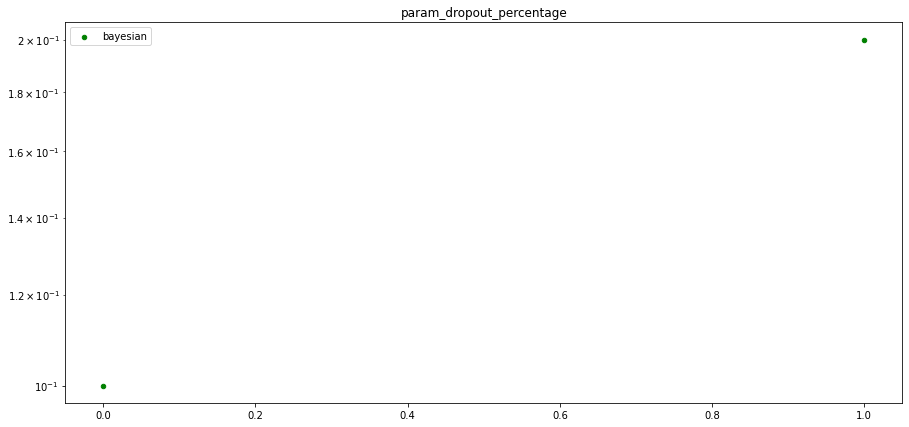

In [25]:
import matplotlib.pyplot as plt

param = 'param_dropout_percentage'

bay = model_bay.cv_results_[param]

fig = plt.figure(figsize=(15, 7))

ax = plt.gca()
ax.scatter(np.arange(len(bay)), bay, c='g', s=20, label='bayesian');
ax.set_yscale('log')

plt.legend();
plt.title(param);

In [ ]:
# GridSearchCV
model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=100)

# Define Hyperparameters that need changing
#optimizer = ['SGD', 'RMSprop']
dropout_percentage = [0.1, 0.2] #0.3]
#hidden_units = [32, 64, 128]
#num_layers = [1, 2, 3]

param_grid = dict(dropout_percentage=dropout_percentage)#,
                  #hidden_units = hidden_units,
                  #num_layers = num_layers)

reg_bay = BayesSearchCV(estimator=model,
                    search_spaces=param_grid,
                    cv=2,
                    n_jobs=1,
                    scoring='roc_auc',\
                    random_state=123)

model_bay = reg_bay.fit(X_train, y_train)